# Simple CNN Models
## loading the library

In [186]:
import os
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from skimage import data
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from keras.utils.vis_utils import plot_model

# Conv2D and Image Filter

A 2D convolution is equivalent to image filter. 

<div><img src="https://i.stack.imgur.com/VRUIm.jpg" width="500"></div>

We demonstrate the equivalence of the conv2D and image filter output.

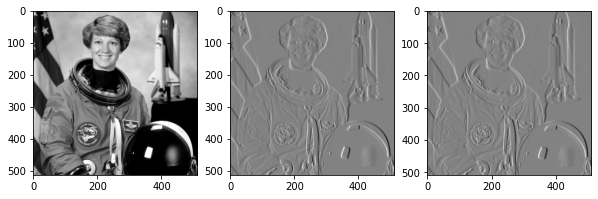

In [191]:
vertical_border = np.array([[1, 1, 0, -1, -1], 
                            [1, 1, 0, -1, -1], 
                            [1, 1, 0, -1, -1],
                            [1, 1, 0, -1, -1],
                            [1, 1, 0, -1, -1]])

img_astronaut = data.astronaut()
img_astronaut_gray = rgb2gray(img_astronaut)

# Using Edge Filter on astronaut
img_astronaut_filtered = sc.ndimage.convolve(img_astronaut_gray, vertical_border)


# Generating Neural Layer with Conv2D
conv_layer_inst = keras.layers.Conv2D(1, kernel_size=(5, 5), use_bias=False)

# Defining input shape
input_layer = tf.TensorShape([None, img_astronaut.shape[0], img_astronaut.shape[1], 1])

# Building the model
conv_layer_inst.build(input_layer)

# Setting Instance weight
conv_layer_inst.set_weights([vertical_border[:, ::-1].reshape((5, 5, 1, 1)).astype(np.float32)])

# Processing astronaut image
img_astronaut_conv = conv_layer_inst(img_astronaut_gray.reshape(1, 512, 512, 1)).numpy()[0][...,0]


fig, axs = plt.subplots(1, 3, figsize=(10, 20))
axs[0].imshow(img_astronaut_gray, cmap=plt.cm.gray)
axs[1].imshow(img_astronaut_filtered, cmap=plt.cm.gray)
axs[2].imshow(img_astronaut_conv, cmap=plt.cm.gray)
plt.show()


# Max Pooling

<div><img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width="400"></div>

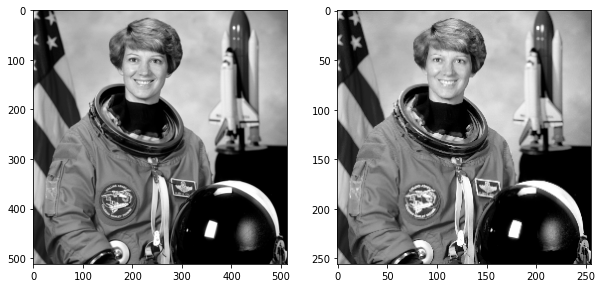

In [72]:
maxpool_inst = keras.layers.MaxPooling2D((2, 2))
input_layer = tf.TensorShape((None, ) + img_astronaut_gray.shape + (1, ))
maxpool_inst.build(input_layer)

img_astronaut_maxpool = maxpool_inst(img_astronaut_gray.reshape((1, 512, 512, 1))).numpy()[0][...,0]

fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs[0].imshow(img_astronaut_gray, cmap=plt.cm.gray)
axs[1].imshow(img_astronaut_maxpool, cmap=plt.cm.gray)
plt.show()


# Data Loading

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

display("x_train shape: {} x {} x {} x {}".format(*x_train.shape))
display("Number of train samples: {} ".format(x_train.shape[0]))
display("Numer of test samples: {}".format(x_test.shape[0]))


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


'x_train shape: 60000 x 28 x 28 x 1'

'Number of train samples: 60000 '

'Numer of test samples: 10000'

# Example Training Data

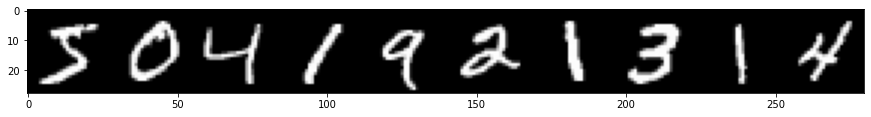

In [21]:
n_example = 10
plt.figure(figsize=(15,15*n_example))
plt.imshow(np.concatenate([x_train[i] for i in range(n_example)], axis=1), cmap=plt.cm.gray)
plt.show()

# Training Model

Trained with a sequential model, containing sequence of `CONV2D` layer, following by a `Dense` layer. 

<div><img src="https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg" width="600"></div>

Loss function measures the model performance in terms of a scalar value. Categorical cross entropy is a common loss function used in multi-class classification problem

$$\mathcal{L} = -\sum^{N}_{i=0}\sum^{M}_{j=0} y_{ij} * log(\hat{y}_{ij})$$



In [221]:
model_path = 'mnist_model'

if os.path.exists(model_path):
    model = keras.models.load_model(model_path)
else:
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    batch_size = 128
    epochs = 15
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    model.save('mnist_model')

In [222]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.035552266985177994
Test accuracy: 0.9876000285148621


In [223]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4

# Model Prediction

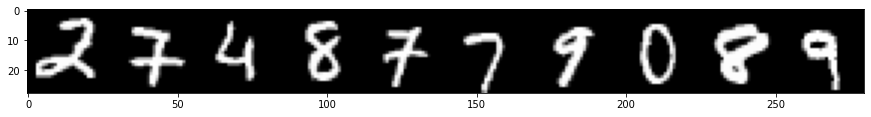

'Predictions: 2 7 4 8 7 7 9 0 8 9 '

In [224]:
idxs = [np.random.randint(x_test.shape[0]) for i in range(n_example)]
prediction = np.argmax(model.predict(x_test[idxs]), axis=1)

plt.figure(figsize=(15,15*n_example))
plt.imshow(np.concatenate([x_test[i] for i in idxs], axis=1), cmap=plt.cm.gray)
plt.show()

display("Predictions: {} ".format(' '.join(['%d' % s for s in prediction])))

# Gradient Computation

In [225]:
x = tf.constant(3.0)

with tf.GradientTape() as g:
    g.watch(x)
    y = x**3 

dy_dx = g.gradient(y, x).numpy()
display("dy/dx = {}".format(dy_dx))

'dy/dx = 27.0'

# GradCAM

<div><img src="https://www.researchgate.net/profile/Johannes-Kvam/publication/343127022/figure/fig1/AS:916034668224512@1595411092305/Overview-of-our-Principal-Feature-Visualisation-PFVmethod.png" width="400"></div>

In [226]:
def gradcam_heatmap(img_array, 
                    model, 
                    last_conv_layer_name, 
                    pred_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



def show_gradient(img, heatmap, alpha=0.1):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("viridis")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha  + (img * 255)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    fig, axs = plt.subplots(1, 2, figsize=(10,20))
    axs[0].imshow(img, cmap=plt.cm.gray)
    axs[1].imshow(superimposed_img)
    plt.show()

# GradCAM example on MNIST

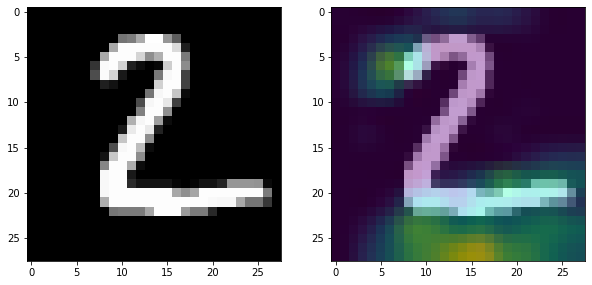

In [227]:
img_array = x_test[[1]]
img_pred = model.predict(img_array)[0]
focus = gradcam_heatmap(img_array, model, 'conv2d_1', np.argmax(img_pred))
show_gradient(img_array[0], focus, alpha=1.0)

# Embedding / Representation Space

In [228]:
emb_model = tf.keras.models.Model(model.inputs, [model.layers[4].output])


random_index = np.random.choice(x_test.shape[0], 600)
emb_vector = emb_model.predict(x_test[random_index])
tags = np.argmax(y_test[random_index], axis=1)

emb_proj = TSNE(n_components=2).fit_transform(emb_vector)

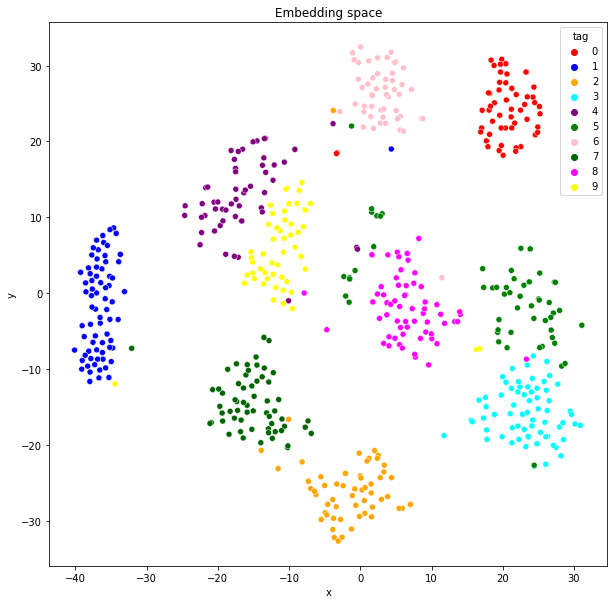

In [229]:
emb_df = pd.DataFrame(emb_proj, columns=['x', 'y'])
emb_df['tag'] = tags

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.scatterplot(data=emb_df, 
                x='x', 
                y='y', 
                hue='tag', 
                ax=ax, 
                palette={0: 'red', 
                         1: 'blue', 
                         2: 'orange',
                         3: 'cyan',
                         4: 'purple',
                         5: 'green',
                         6: 'pink',
                         7: 'darkgreen',
                         8: 'magenta',
                         9: 'yellow',
                        })
plt.title('Embedding space')
plt.show()

# Embedding Is Guided by Task

## Same Data Different Task

Instead of digit recognition we convert the model into odd even recognition problem. Odd {1, 3, 5, 7, 9}, Even {0, 2, 4, 6, 8}

In [198]:
y_test_odd_even = (np.argmax(y_test, axis=1) % 2 == 0).astype(int)
y_train_odd_even = (np.argmax(y_train, axis=1) % 2 == 0).astype(int)

model_path = 'mnist_oddeven'

if os.path.exists(model_path):
    model_oddeven = keras.models.load_model(model_path)
else:
    model_oddeven = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    
    batch_size = 128
    epochs = 15
    model_oddeven.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model_oddeven.fit(x_train, y_train_odd_even, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    model_oddeven.save(model_path)


Epoch 1/15
422/422 [==============================] - 32s 73ms/step - loss: 0.2522 - accuracy: 0.8944 - val_loss: 0.0895 - val_accuracy: 0.9705
Epoch 2/15
422/422 [==============================] - 35s 83ms/step - loss: 0.1185 - accuracy: 0.9561 - val_loss: 0.0689 - val_accuracy: 0.9753
Epoch 3/15
422/422 [==============================] - 33s 78ms/step - loss: 0.0912 - accuracy: 0.9676 - val_loss: 0.0549 - val_accuracy: 0.9823
Epoch 4/15
422/422 [==============================] - 33s 78ms/step - loss: 0.0804 - accuracy: 0.9705 - val_loss: 0.0471 - val_accuracy: 0.9852
Epoch 5/15
422/422 [==============================] - 32s 77ms/step - loss: 0.0722 - accuracy: 0.9740 - val_loss: 0.0479 - val_accuracy: 0.9833
Epoch 6/15
422/422 [==============================] - 28s 67ms/step - loss: 0.0648 - accuracy: 0.9776 - val_loss: 0.0419 - val_accuracy: 0.9860
Epoch 7/15
422/422 [==============================] - 31s 73ms/step - loss: 0.0615 - accuracy: 0.9782 - val_loss: 0.0420 - val_accuracy:

# Checking Odd Even Model

Displaying the model accuracy of the odd even model task

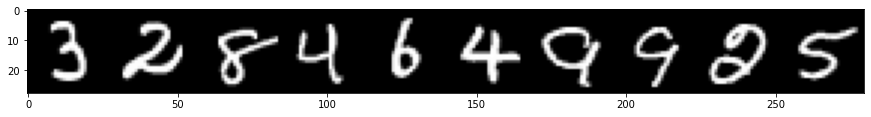

'Predictions: 0 1 1 1 1 1 0 0 1 0 '

In [205]:
idxs = [np.random.randint(x_test.shape[0]) for i in range(n_example)]
prediction = np.round(model_oddeven.predict(x_test[idxs]).reshape(-1))

plt.figure(figsize=(15,15*n_example))
plt.imshow(np.concatenate([x_test[i] for i in idxs], axis=1), cmap=plt.cm.gray)
plt.show()

display("Predictions: {} ".format(' '.join(['%d' % s for s in prediction])))

# Representation Space For Odd Even Task

In [230]:
emb_model_oddeven = tf.keras.models.Model(model_oddeven.inputs, [model_oddeven.layers[4].output])


random_index = np.random.choice(x_test.shape[0], 600)
emb_vector = emb_model_oddeven.predict(x_test[random_index])
tags = y_test[random_index]

emb_proj = TSNE(n_components=2).fit_transform(emb_vector)

# Plotting the embedding space

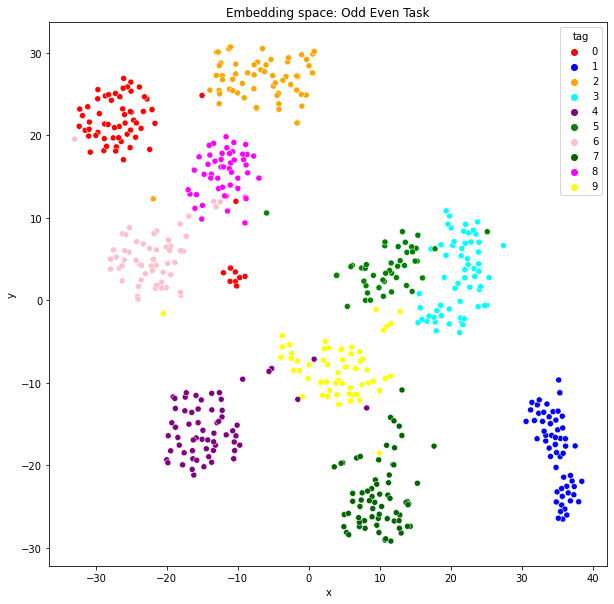

In [231]:
emb_df = pd.DataFrame(emb_proj, columns=['x', 'y'])
emb_df['tag'] = np.argmax(y_test[random_index], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.scatterplot(data=emb_df, 
                x='x', 
                y='y', 
                hue='tag', 
                ax=ax, 
                palette={0: 'red', 
                         1: 'blue', 
                         2: 'orange',
                         3: 'cyan',
                         4: 'purple',
                         5: 'green',
                         6: 'pink',
                         7: 'darkgreen',
                         8: 'magenta',
                         9: 'yellow',
                        })
plt.title('Embedding space: Odd Even Task')
plt.show()